In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 5


data = {
    "CPR": load_data("thermal_cpr", n_newest=NUM_SIMS),
    "Schur": load_data("thermal_schur", n_newest=NUM_SIMS),
    "Dynamic": load_data("thermal_dynamic", n_newest=NUM_SIMS),
    "Random": load_data("thermal_random", n_newest=NUM_SIMS),
}

# save_media_path = Path('/dev/null')
save_media_path = None

Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_17.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_18.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_19.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_20.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_cpr_21.npy


/home/firedrake/workspace/porepy_workspace/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_10.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_11.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_12.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_13.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_schur_14.npy
Loading data:
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_dynamic_24.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_dynamic_25.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_dynamic_26.npy
/home/firedrake/workspace/porepy_workspace/solver_selector/examples/1/performance/thermal_dynamic_27.npy
/home/firedrake/workspace/porepy_work

In [2]:
data['Dynamic'][0][0].nonlinear_solver_stats.iterations

[NonlinearIterationStats(work_time=0.29327821731567383, solve_linear_system_time=0.009161710739135742, assembly_time=0.22122430801391602, update_preconditioner_time=0.06271243095397949, linear_solver_converged=True, num_linear_iterations=2, linear_residual_decrease=3.69324824937681e-11),
 NonlinearIterationStats(work_time=0.28135180473327637, solve_linear_system_time=0.008257150650024414, assembly_time=0.22055387496948242, update_preconditioner_time=0.052350521087646484, linear_solver_converged=True, num_linear_iterations=3, linear_residual_decrease=2.758119500803358e-13),
 NonlinearIterationStats(work_time=0.30342841148376465, solve_linear_system_time=0.008005619049072266, assembly_time=0.24045205116271973, update_preconditioner_time=0.05478477478027344, linear_solver_converged=True, num_linear_iterations=3, linear_residual_decrease=1.531113019603115e-13)]

CPR 122.18767876625061 1.4231457710266113
Schur 72.91204872131348 2.359184980392456
Dynamic 59.222565269470216 7.242836236953735
Random 98.49394636154175 11.71674370765686


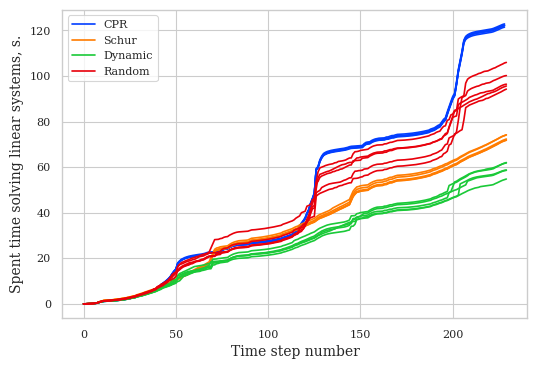

In [3]:
color_iter = -1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    results = [
        sum_per_time_step(
            make_solve_linear_system_time(perf, converged=CONVERGED),
            perf,
            converged=CONVERGED,
        )
        for perf in values
    ]
    color_iter += 1
    make_label = True
    total = []
    for result in results:
        result = np.cumsum(result)
        total.append(result[-1])
        if make_label:
            plt.plot(result, color=f"C{color_iter}", label=name)
            make_label = False
        else:
            plt.plot(result, color=f"C{color_iter}")
    print(name, np.mean(total), np.max(total) - np.min(total))

plt.legend()
plt.xlabel("Time step number")
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR 122.18767876625061 1.4231457710266113
Schur 72.91204872131348 2.359184980392456
Dynamic 59.222565269470216 7.242836236953735
Random 98.49394636154175 11.71674370765686


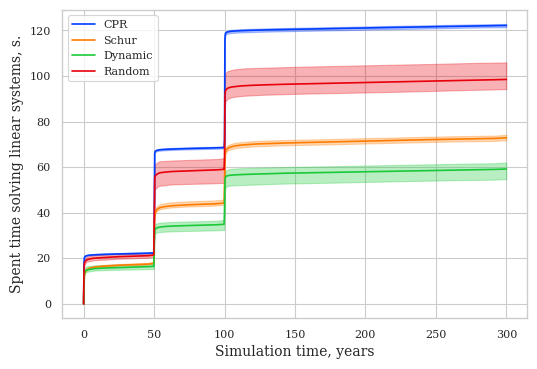

In [4]:
DAY = 24 * 60 * 60
YEAR = 365 * DAY


color_iter = -1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    results = []
    times = []
    color_iter += 1

    for perf in values:
        results.append(
            np.cumsum(
                sum_per_time_step(
                    make_solve_linear_system_time(perf, converged=CONVERGED),
                    perf,
                    converged=CONVERGED,
                )
            )
        )
        times.append(make_simulation_time(perf, converged=CONVERGED))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, results):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if name == 'Dynamic':
        best = mean
    x_space /= YEAR
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel("Simulation time, years")
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

CPR 122.18767876625061 1.4231457710266113
Schur 72.91204872131348 2.359184980392456
Dynamic 59.222565269470216 7.242836236953735
Random 98.49394636154175 11.71674370765686


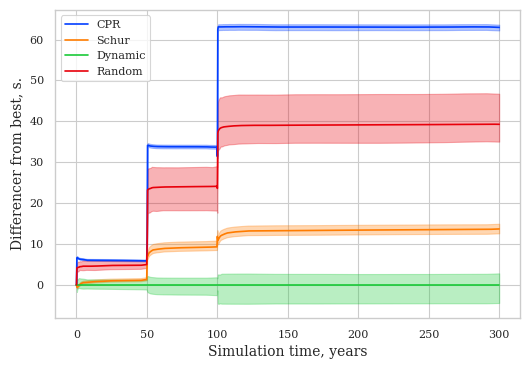

In [5]:
DAY = 24 * 60 * 60
YEAR = 365 * DAY


color_iter = -1
plt.figure(figsize=(6, 4))
for name, values in data.items():
    results = []
    times = []
    color_iter += 1

    for perf in values:
        results.append(
            np.cumsum(
                sum_per_time_step(
                    make_solve_linear_system_time(perf, converged=CONVERGED),
                    perf,
                    converged=CONVERGED,
                )
            )
        )
        times.append(make_simulation_time(perf, converged=CONVERGED))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, results):
        total.append(result[-1])
        t_end.append(time[-1])

        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0) - best
    min_ = np.min(interp_data, axis=0) - best
    mean = np.mean(interp_data, axis=0) - best
    x_space /= YEAR
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel("Simulation time, years")
plt.ylabel("Differencer from best, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

0


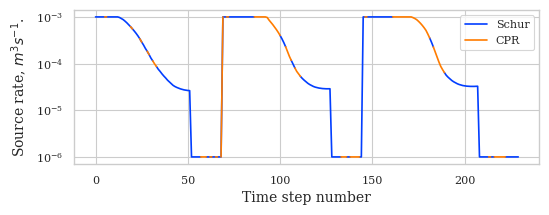

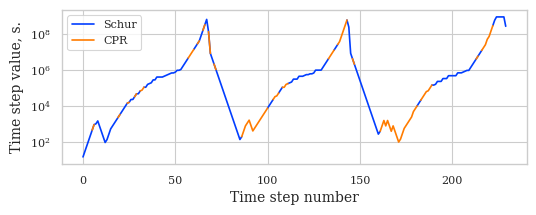

1


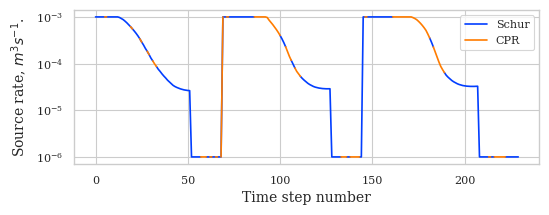

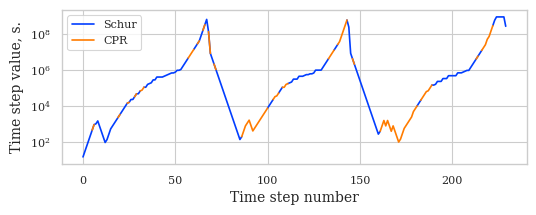

2


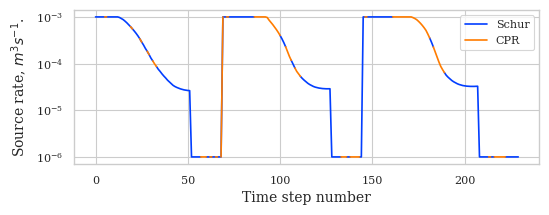

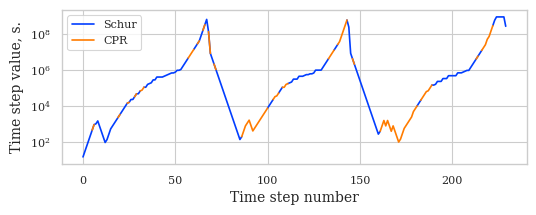

3


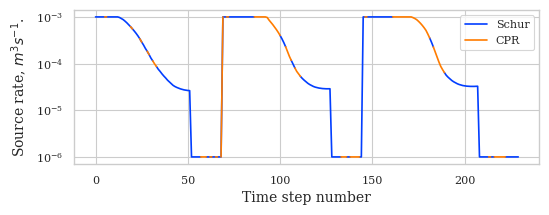

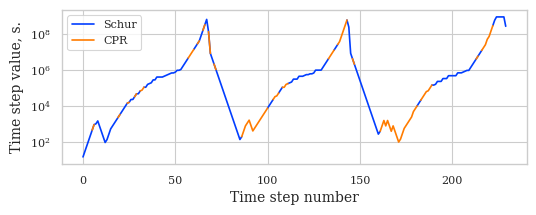

4


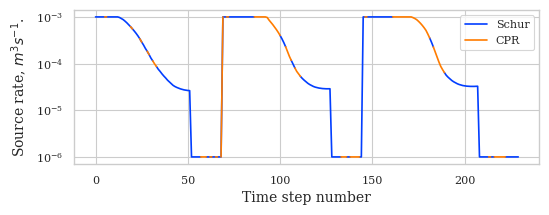

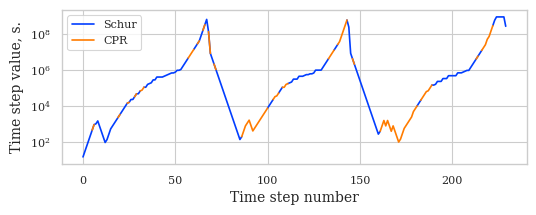

In [6]:
def color_using_schur(using_schur, values, x=None):
    using_schur = np.array(using_schur).copy()
    using_cpr = ~using_schur
    using_schur[1:] += using_schur[:-1]
    using_schur[:-1] += using_schur[1:]
    if x is not None:
        plt.plot(x, np.where(using_schur, values, None), label="Schur")
        plt.plot(x, np.where(using_cpr, values, None), label="CPR")
    else:
        plt.plot(np.where(using_schur, values, None), label="Schur")
        plt.plot(np.where(using_cpr, values, None), label="CPR")
    plt.legend()


def make_using_schur_indices(perf: Sequence[SolverSelectionData], converged=True):
    using_schur = np.array(
        ["schur_cd" in data.config["gmres"]["preconditioner"] for data in perf]
    )
    if converged:
        return using_schur[make_converged_indices(perf)]
    return using_schur


def plot_characteristics_color_schur(perf):
    using_schur = make_using_schur_indices(perf, converged=CONVERGED)
    time_step = make_time_step(perf, converged=CONVERGED)
    inlet_rate = make_inlet_rate(perf, converged=CONVERGED)
    # x = make_simulation_time(perf, converged=CONVERGED)
    x = None

    plt.figure(figsize=(6, 2))
    color_using_schur(using_schur, inlet_rate, x)
    plt.ylabel("Source rate, $m^3 s^{-1}$.")
    plt.xlabel("Time step number")
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / "thermal_source.pdf", bbox_inches="tight")

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel("Time step number")
    color_using_schur(using_schur, time_step, x)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / "thermal_dt.pdf", bbox_inches="tight")


for i, perf in enumerate(data["Dynamic"]):
    print(i)
    plot_characteristics_color_schur(data["Dynamic"][0])
    plt.show()

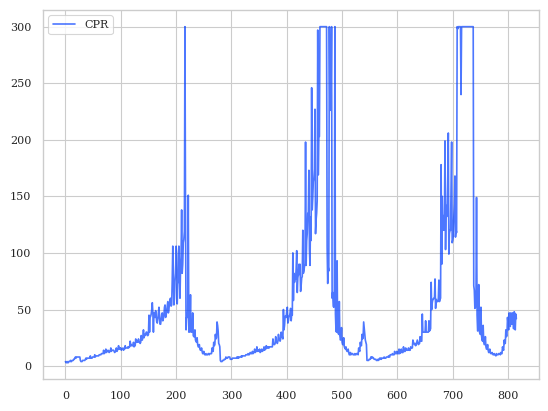

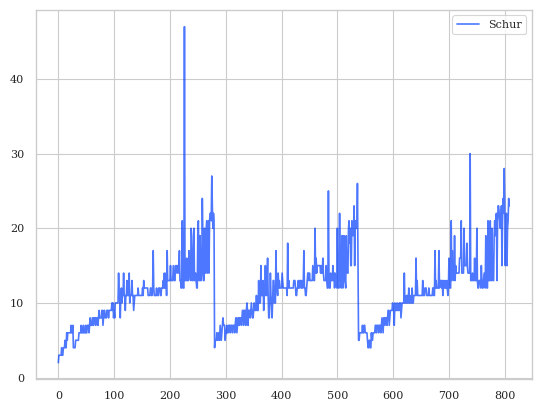

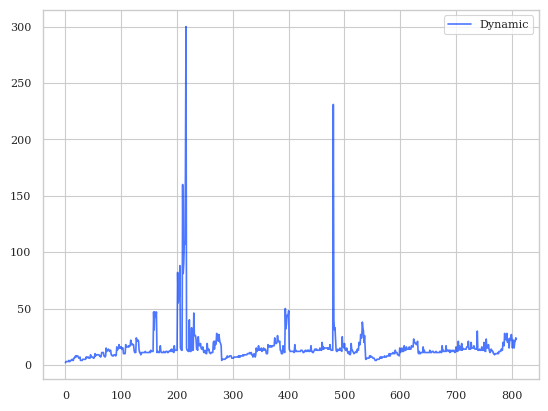

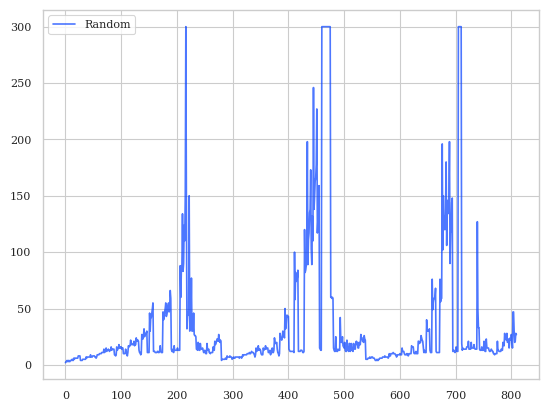

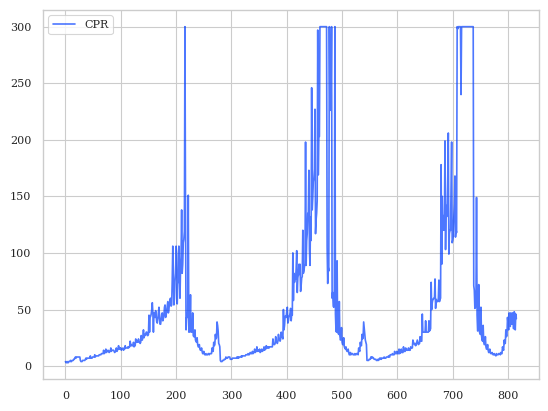

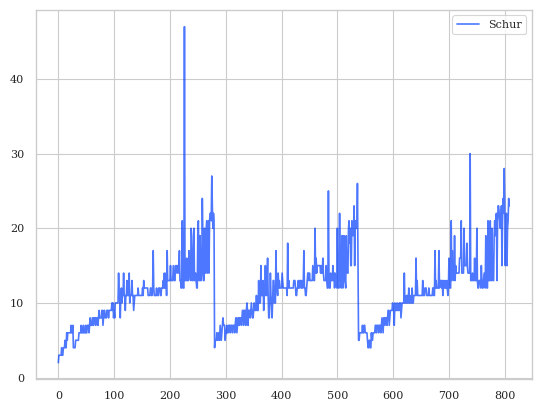

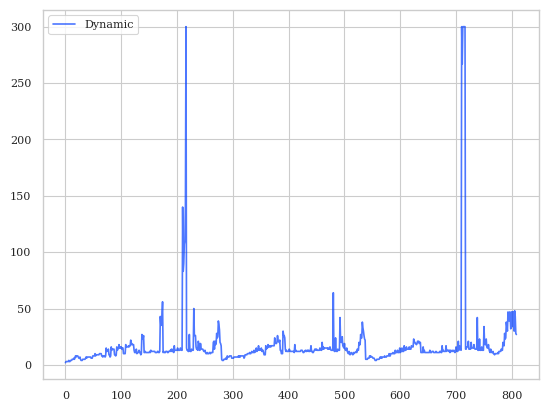

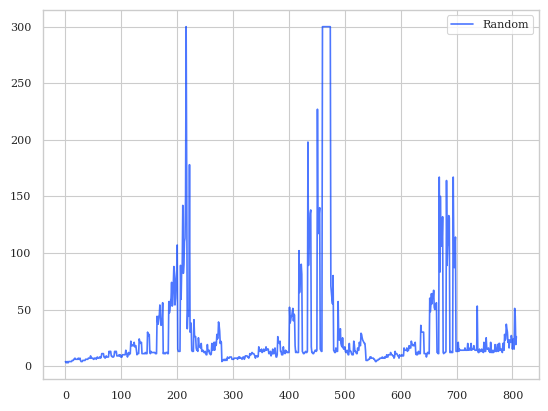

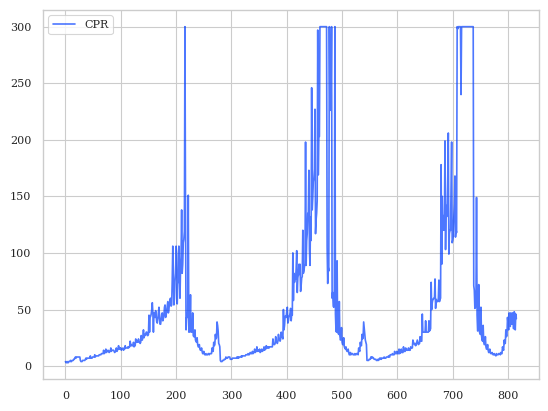

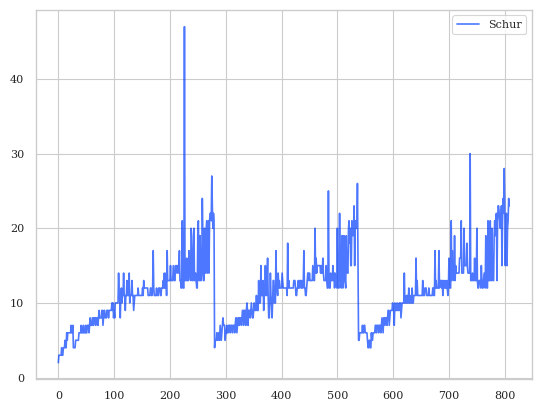

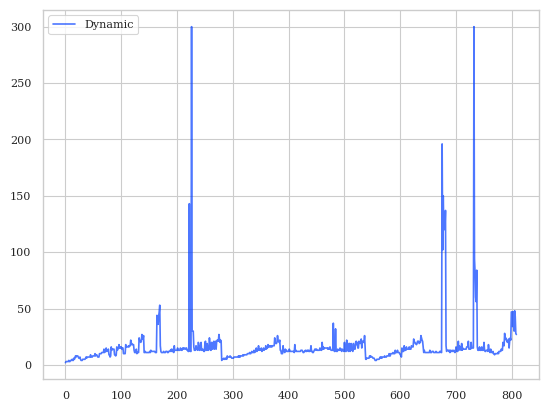

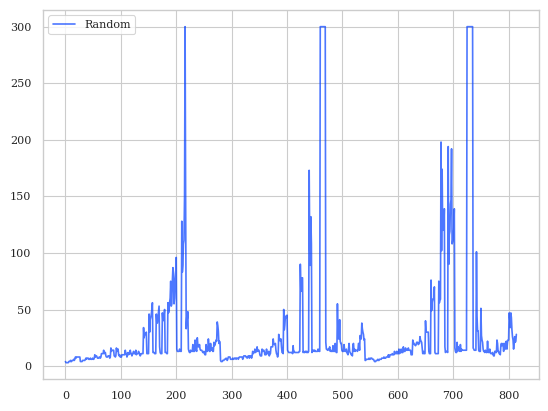

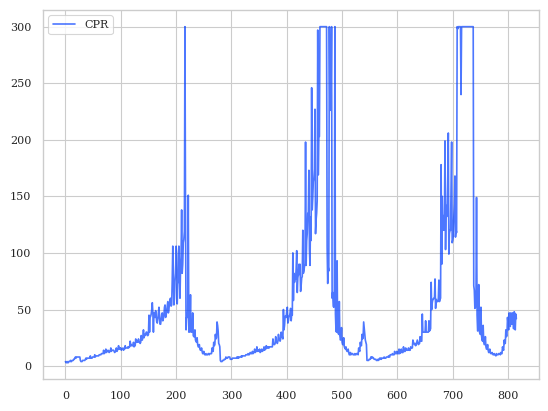

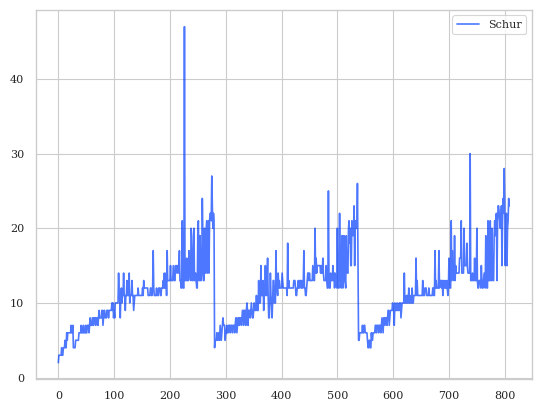

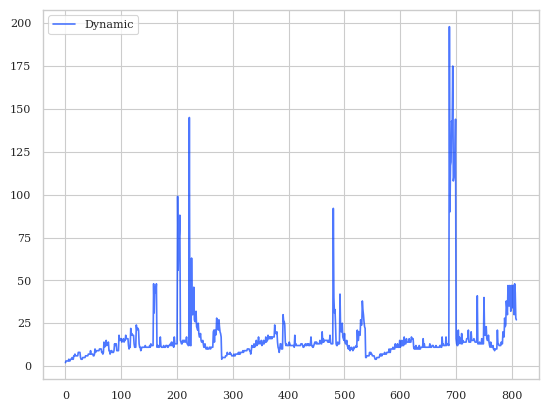

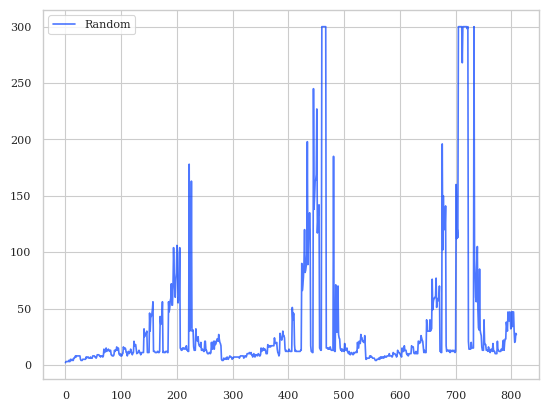

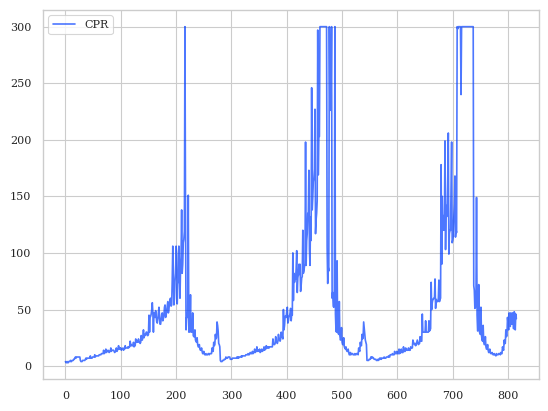

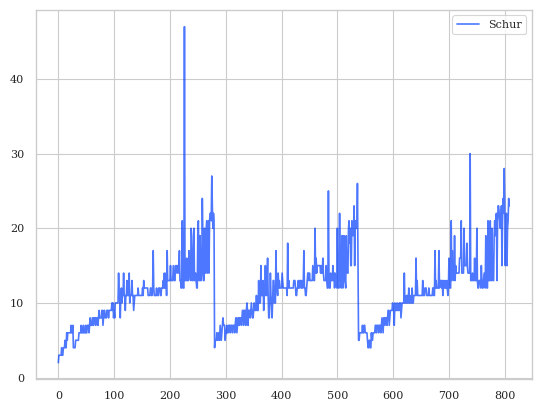

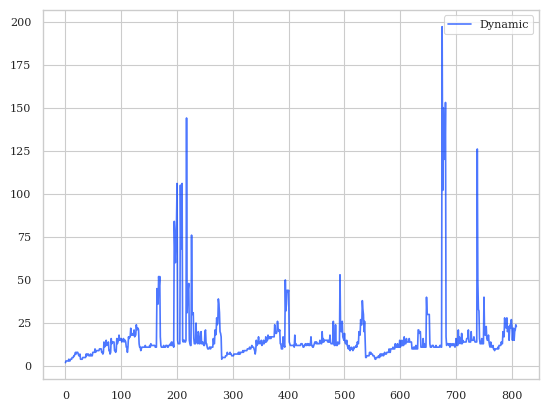

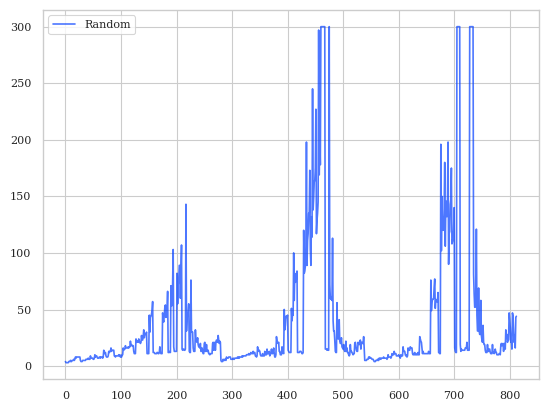

In [7]:
for i in range(NUM_SIMS):
    for name, values in data.items():
        plt.figure()
        value = values[i]
        num_iters = make_num_linear_iters(value)
        plt.plot(num_iters, label=name, alpha=0.7)
        plt.legend()